In [15]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [16]:
%matplotlib inline

In [17]:
from relaxed.plot_defaults import *

In [18]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [19]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_an_from_am, get_lam, get_ma, get_gradient, get_fractional_tdyn

# predictions with gradients

## Collect data

In [3]:
# # catalog
# hcat, indices, scales = setup('m11', path='../../../output/30k')
# xoff = hcat.cat['xoff']
# cvir = hcat.cat['cvir']
# eta = hcat.cat['eta']


# # obtain ma
# ma, keep1 = get_ma(hcat.cat, indices)

# # obtain a_m
# am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# # throw away first & last, useless bin (a = 1.00 always for that)
# am = am[:, 1:-1]
# mass_bins = mass_bins[1:-1]

# #lam 
# lam, keep2 = get_lam(am)

# # cuts
# ma = ma[keep1 & keep2]
# am = am[keep1 & keep2]
# hcat.cat = hcat.cat[keep1 & keep2]
# cvir, xoff, eta = cvir[keep1 & keep2], xoff[keep1 & keep2], eta[keep1 & keep2]

# # gradients
# grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
# grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)


# print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape)
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']


# obtain ma
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]

#lam 
lam, keep2 = get_lam(am)

# cuts
ma = ma[keep2]
am = am[keep2]
hcat.cat = hcat.cat[keep2]
cvir, xoff, eta = cvir[keep2], xoff[keep2], eta[keep2]

# gradients
grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)


print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape)

(28366, 98) (28366, 171) (28366, 171) (28366, 171) (98,) (28366,) (28366,) (28366,)


In [4]:
# train/test split
from sklearn.model_selection import train_test_split

am_train, am_test, grads4_train, grads4_test, grads20_train, grads20_test, eta_train, eta_test, xoff_train, xoff_test, cvir_train, cvir_test  = train_test_split(am, grads4, grads20, eta, xoff, cvir, test_size=0.2)
print(am_train.shape, grads4_train.shape, grads20_train.shape, eta_train.shape)

(22692, 98) (22692, 171) (22692, 171) (22692,)


## Train!

In [5]:
from relaxed.analysis import training_suite

In [7]:
# try to predict eta as a test case. 

# first collect all the features
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])

# then train the models using specific features
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
# eta_models4, _ = training_suite(train_features4, eta_train, suite=("MV-TLR"), extra_args=extra_args)
# eta_models20, _ = training_suite(train_features20, eta_train, suite=("MV-TLR",), extra_args=extra_args)
eta_models_no_grad, _ = training_suite(am_train, eta_train, suite=("MV-TLR","CAM", "LN-RS"), extra_args=extra_args)

# extra_args.update({'mrange': (0.498, 0.51)})
# eta_models_cam2, _ = training_suite(am_train, eta_train, suite=("CAM",), extra_args=extra_args)
eta_models = {
#               'MV-TLR-4': eta_models4['MV-TLR'], 
#               'MV-TLR-20': eta_models20['MV-TLR'], 
              'MV-TLR-no_grad':eta_models_no_grad['MV-TLR'], 
              'CAM1': eta_models_no_grad['CAM'],
#               'CAM2': eta_models_cam2['CAM'],
             }

In [28]:
# try to predict xoff
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])
xoff_models4, _ = training_suite(train_features4, xoff_train, suite=("LN-RS", "CAM", "MV-TLR"), extra_args=extra_args)
xoff_models20, _ = training_suite(train_features20, xoff_train, suite=("MV-TLR",), extra_args=extra_args)
xoff_models_no_grad, _ = training_suite(am_train, xoff_train, suite=("MV-TLR",), extra_args=extra_args)
xoff_models = {'MV-TLR-4': xoff_models4['MV-TLR'], 
              'MV-TLR-20': xoff_models20['MV-TLR'], 
              'MV-TLR-no_grad': xoff_models_no_grad['MV-TLR'], 
              'CAM': xoff_models4['CAM']
             }

In [41]:
# try to predict cvir
extra_args = {'cam_order': -1, 'mass_bins': mass_bins, 'mrange':(.394, 0.402), 'am_train': am_train}
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])
cvir_models4, _ = training_suite(train_features4, cvir_train, suite=("LN-RS", "CAM", "MV-TLR"), extra_args=extra_args)
cvir_models20, _ = training_suite(train_features20, cvir_train, suite=("MV-TLR",), extra_args=extra_args)
cvir_models_no_grad, _ = training_suite(am_train, cvir_train, suite=("MV-TLR",), extra_args=extra_args)
cvir_models = {'MV-TLR-4': cvir_models4['MV-TLR'], 
              'MV-TLR-20': cvir_models20['MV-TLR'], 
              'MV-TLR-no_grad': cvir_models_no_grad['MV-TLR'], 
              'CAM': cvir_models4['CAM']
             }

In [17]:
# cvir with 2 CAMs
extra_args = {'cam_order': -1, 'mass_bins': mass_bins, 'mrange':(.394, 0.402), 'am_train': am_train}
cvir_models1, _ = training_suite(am_train, cvir_train, suite=('CAM', 'MV-TLR'), extra_args=extra_args)
extra_args.update({'mrange': (0.498, 0.51)})
cvir_models2, _ = training_suite(am_train, cvir_train, suite=("CAM",), extra_args=extra_args)
cvir_models = {'MV-TLR': cvir_models1['MV-TLR'], 
              'CAM1': cvir_models1['CAM'], 
              'CAM2': cvir_models2['CAM'], 
             }

## Plots

In [8]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(data, Y_test, trained_models, colors=('r', 'b', 'g'), models=("CAM"), names=("\\rm CAM"),
                       n_bins=31, latex_var="", xrange=(-2, 2), **kwargs):
    assert 'am_test' in kwargs
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    bins = None
    for i, m in enumerate(models): 
        model = trained_models[m]
        Y_pred = model(data[m], **kwargs)
        x = (Y_pred - Y_test) / Y_test
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        print(f'{models[i]} corr: {scipy.stats.spearmanr(Y_pred, Y_test)[0]}')
        RMSE =  np.sqrt(np.mean(((Y_pred - Y_test) / Y_test)**2))
        print(f'{models[i]} RMSE: {RMSE}')
        label = f'{names[i]}, RMSE={RMSE:.3f}'
        draw_histogram(ax, x, vline=None, label=label, color=colors[i], 
                       bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.legend(loc='best', prop={'size':24})
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

MV-TLR-4 corr: 0.7059118381212531
MV-TLR-4 RMSE: 0.05365041937978066
MV-TLR-20 corr: 0.7087828700411137
MV-TLR-20 RMSE: 0.05382531788244786
MV-TLR-no_grad corr: 0.6829878770669253
MV-TLR-no_grad RMSE: 0.05296222445962618


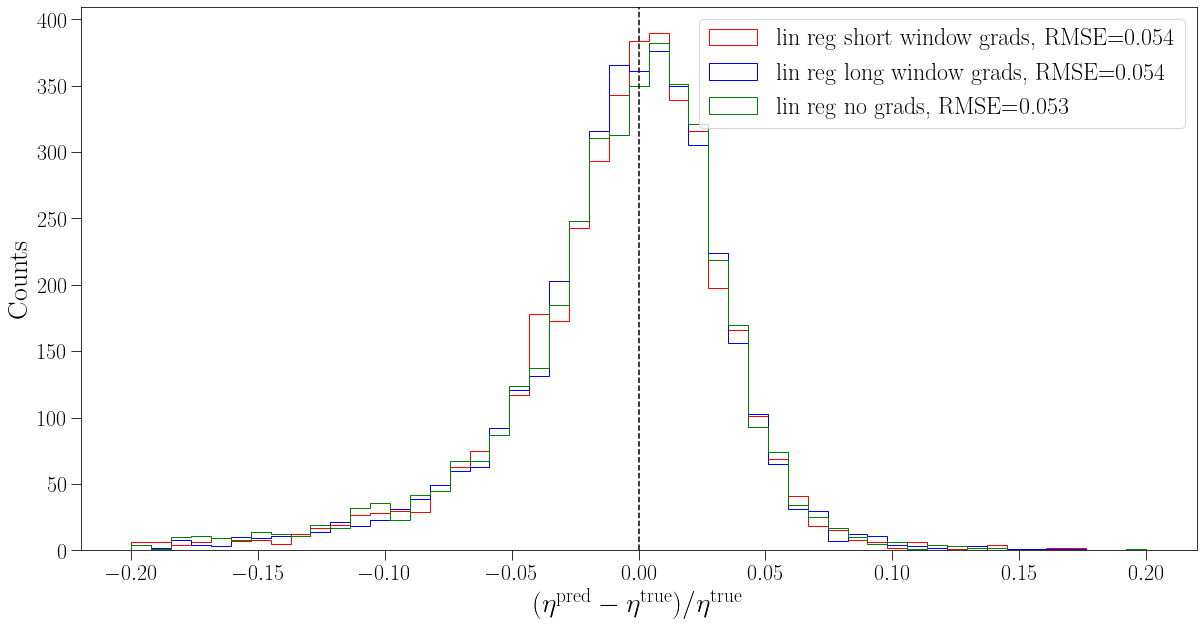

In [40]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, eta_test, eta_models, colors=colors, names=names, models=models, latex_var=r'\eta', 
                   n_bins=51, xrange=(-0.2, 0.2), am_test=am_test)

MV-TLR-4 corr: 0.4821632899713105
MV-TLR-4 RMSE: 0.9628535524459843
MV-TLR-20 corr: 0.4831253355369746
MV-TLR-20 RMSE: 0.9481544747172329
MV-TLR-no_grad corr: 0.4832150695551464
MV-TLR-no_grad RMSE: 0.917191867625848


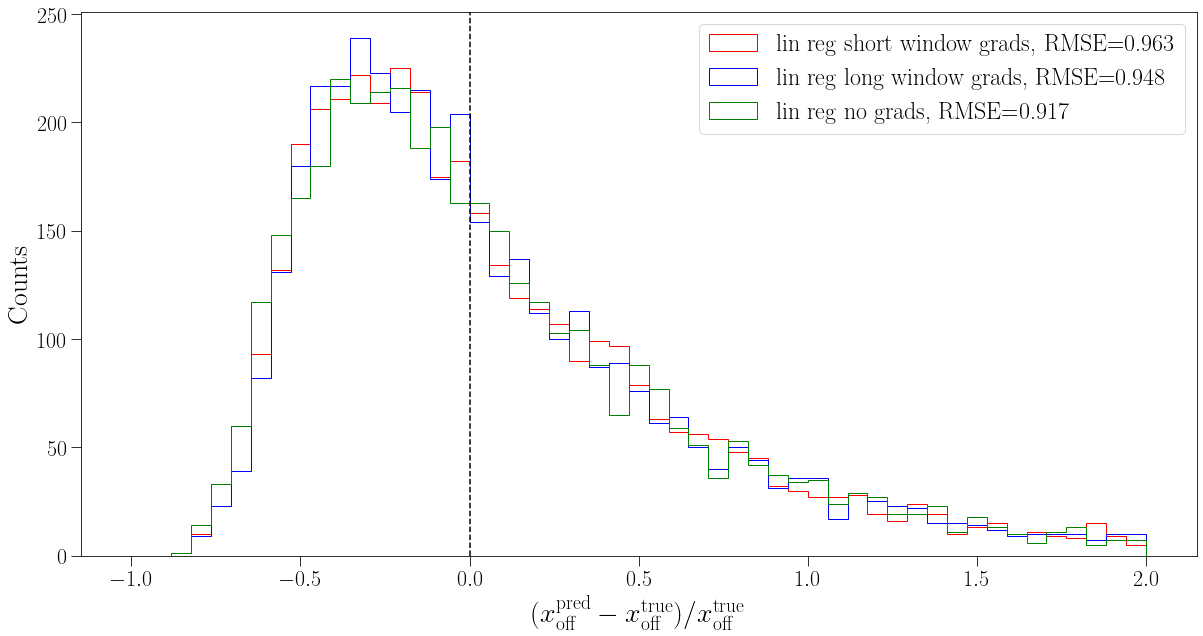

In [42]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, xoff_test, xoff_models, colors=colors, names=names, models=models, latex_var=r'x_{\rm off}', 
                   n_bins=51, xrange=(-1, 2), am_test=am_test)

MV-TLR-4 corr: 0.7966113699485073
MV-TLR-4 RMSE: 0.3510486277594051
MV-TLR-20 corr: 0.7944817544195688
MV-TLR-20 RMSE: 0.35710462962474915
MV-TLR-no_grad corr: 0.7701622689615925
MV-TLR-no_grad RMSE: 0.3382013828982824


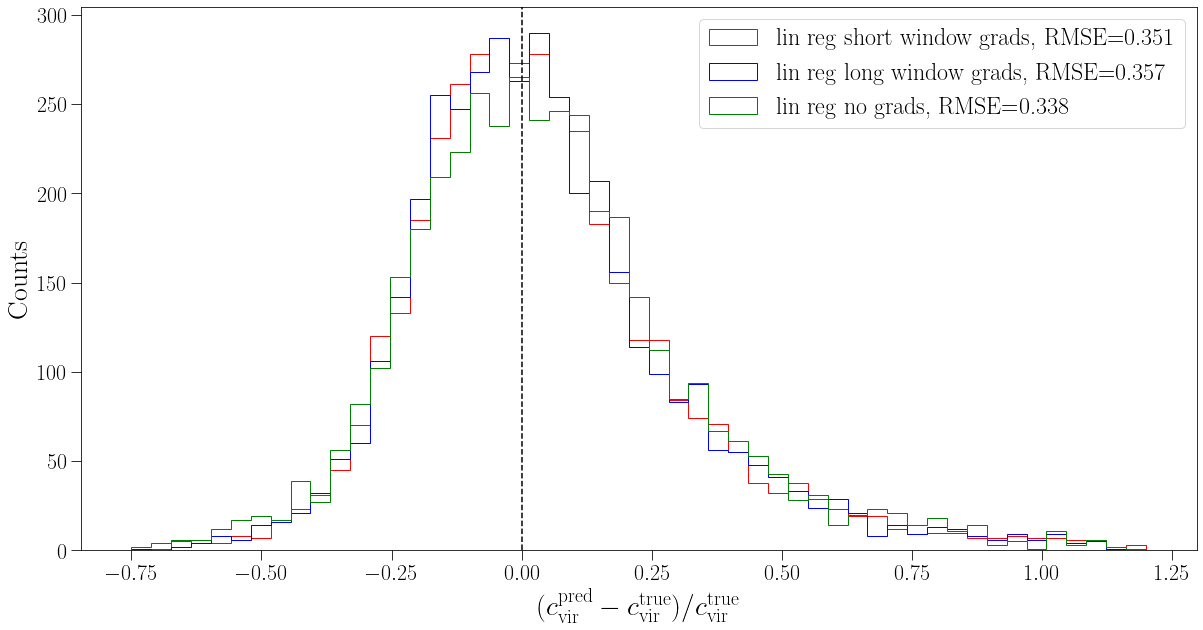

In [45]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, cvir_test, cvir_models, colors=colors, names=names, models=models, latex_var=r'c_{\rm vir}', 
                   n_bins=51, xrange=(-.75, 1.2), am_test=am_test)

CAM1 corr: 0.6825616641826968
CAM1 RMSE: 0.3512874321669475
CAM2 corr: 0.682562346609366
CAM2 RMSE: 0.3932709638677639
MV-TLR corr: 0.7571767818311554
MV-TLR RMSE: 0.3686253123808684


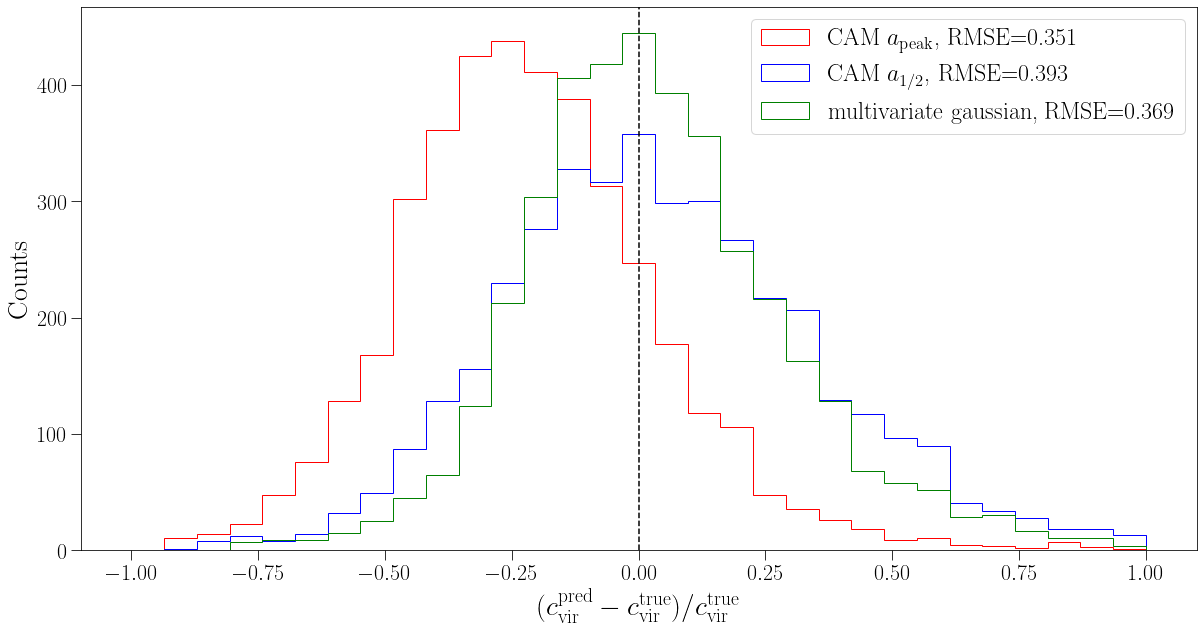

In [21]:
models = ['CAM1', 'CAM2', 'MV-TLR']
names = ["\\rm CAM $a_{\\rm peak}$","\\rm CAM $a_{1/2}$", "\\rm multivariate gaussian"]
colors = ['r', 'b', 'g']
data = {m:am_test for m in models}
combined_histogram(data, cvir_test, cvir_models, colors=colors, names=names, models=models, latex_var=r'c_{\rm vir}', 
                   n_bins=31, xrange=(-1.0, 1.0), am_test=am_test)

In [9]:
np.mean((eta_models['CAM1'](am_test, am_test=am_test) - eta_test)/ eta_test)

0.0014030233176116813

CAM1 corr: 0.628276048570299
CAM1 RMSE: 0.06880691837197396
MV-TLR-no_grad corr: 0.7347089008864017
MV-TLR-no_grad RMSE: 0.05341473493033707


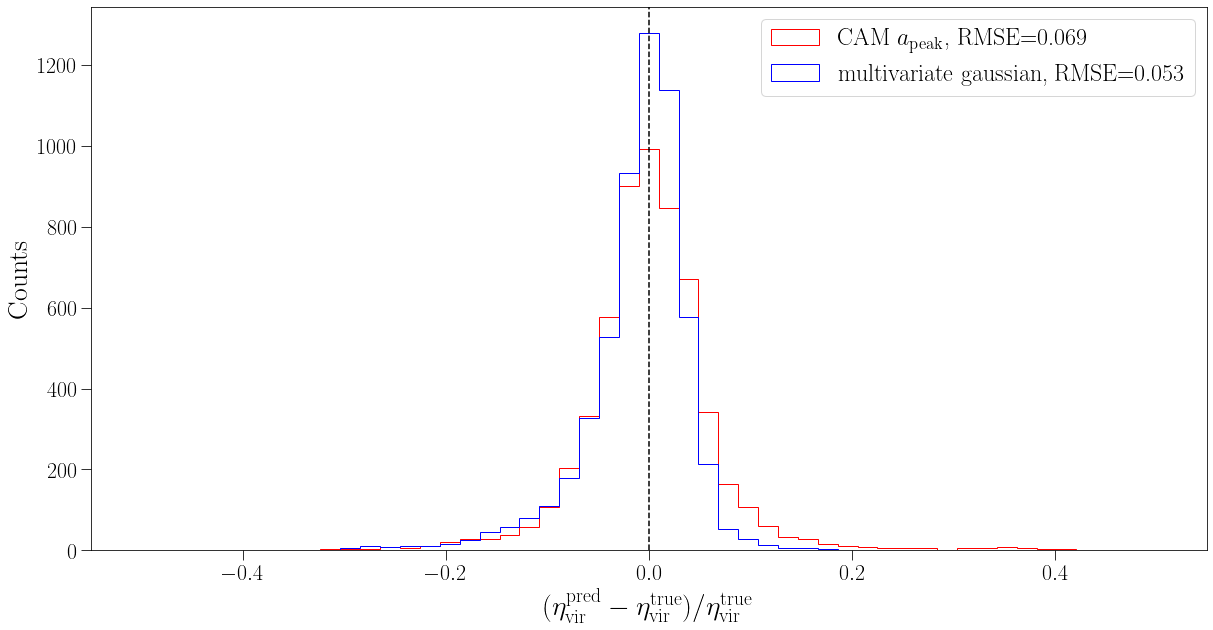

In [20]:
models = ['CAM1', 'MV-TLR-no_grad']
names = ["\\rm CAM $a_{\\rm peak}$","\\rm multivariate gaussian"]
colors = ['r', 'b', 'g']
data = {m:am_test for m in models}
combined_histogram(data, eta_test, eta_models, colors=colors, names=names, models=models, latex_var=r'\eta_{\rm vir}', 
                   n_bins=51, xrange=(-0.5, 0.5), am_test=am_test)

# predictions with gradients

## Collect data

In [12]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']


# obtain ma
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]

#lam 
lam, keep2 = get_lam(am)

# cuts
ma = ma[keep1 & keep2]
am = am[keep1 & keep2]
hcat.cat = hcat.cat[keep1 & keep2]
cvir, xoff, eta = cvir[keep1 & keep2], xoff[keep1 & keep2], eta[keep1 & keep2]

# gradients
grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)


print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape)

(19712, 98) (19712, 171) (19712, 171) (19712, 171) (98,) (19712,) (19712,) (19712,)


In [14]:
# train/test split
from sklearn.model_selection import train_test_split

am_train, am_test, grads4_train, grads4_test, grads20_train, grads20_test, eta_train, eta_test, xoff_train, xoff_test, cvir_train, cvir_test  = train_test_split(am, grads4, grads20, eta, xoff, cvir, test_size=0.2)
print(am_train.shape, grads4_train.shape, grads20_train.shape, eta_train.shape)

(15769, 98) (15769, 171) (15769, 171) (15769,)


## Train!

In [16]:
from relaxed.analysis import training_suite

In [15]:
# try to predict eta as a test case. 
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])
eta_models4, _ = training_suite(train_features4, eta_train, suite=("LN-RS", "CAM", "MV-TLR"), extra_args=extra_args)
eta_models20, _ = training_suite(train_features20, eta_train, suite=("MV-TLR",), extra_args=extra_args)
eta_models_no_grad, _ = training_suite(am_train, eta_train, suite=("MV-TLR",), extra_args=extra_args)
eta_models = {'MV-TLR-4': eta_models4['MV-TLR'], 
              'MV-TLR-20': eta_models20['MV-TLR'], 
              'MV-TLR-no_grad':eta_models_no_grad['MV-TLR'], 
              'CAM': eta_models4['CAM']
             }

In [28]:
# try to predict xoff
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(0.73, 0.74), 'am_train': am_train}
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])
xoff_models4, _ = training_suite(train_features4, xoff_train, suite=("LN-RS", "CAM", "MV-TLR"), extra_args=extra_args)
xoff_models20, _ = training_suite(train_features20, xoff_train, suite=("MV-TLR",), extra_args=extra_args)
xoff_models_no_grad, _ = training_suite(am_train, xoff_train, suite=("MV-TLR",), extra_args=extra_args)
xoff_models = {'MV-TLR-4': xoff_models4['MV-TLR'], 
              'MV-TLR-20': xoff_models20['MV-TLR'], 
              'MV-TLR-no_grad': xoff_models_no_grad['MV-TLR'], 
              'CAM': xoff_models4['CAM']
             }

In [41]:
# try to predict cvir
extra_args = {'cam_order': -1, 'mass_bins': mass_bins, 'mrange':(.394, 0.402), 'am_train': am_train}
train_features4 = np.hstack([am_train, grads4_train])
test_features4 = np.hstack([am_test, grads4_test])
train_features20 = np.hstack([am_train, grads20_train])
test_features20 = np.hstack([am_test, grads20_test])
cvir_models4, _ = training_suite(train_features4, cvir_train, suite=("LN-RS", "CAM", "MV-TLR"), extra_args=extra_args)
cvir_models20, _ = training_suite(train_features20, cvir_train, suite=("MV-TLR",), extra_args=extra_args)
cvir_models_no_grad, _ = training_suite(am_train, cvir_train, suite=("MV-TLR",), extra_args=extra_args)
cvir_models = {'MV-TLR-4': cvir_models4['MV-TLR'], 
              'MV-TLR-20': cvir_models20['MV-TLR'], 
              'MV-TLR-no_grad': cvir_models_no_grad['MV-TLR'], 
              'CAM': cvir_models4['CAM']
             }

In [17]:
# cvir with 2 CAMs
extra_args = {'cam_order': -1, 'mass_bins': mass_bins, 'mrange':(.394, 0.402), 'am_train': am_train}
cvir_models1, _ = training_suite(am_train, cvir_train, suite=('CAM', 'MV-TLR'), extra_args=extra_args)
extra_args.update({'mrange': (0.498, 0.51)})
cvir_models2, _ = training_suite(am_train, cvir_train, suite=("CAM",), extra_args=extra_args)
cvir_models = {'MV-TLR': cvir_models1['MV-TLR'], 
              'CAM1': cvir_models1['CAM'], 
              'CAM2': cvir_models2['CAM'], 
             }

In [24]:
# eta with 2 CAMs, no gradients. 
extra_args = {'cam_order': +1, 'mass_bins': mass_bins, 'mrange':(.73, 0.74), 'am_train': am_train}
eta_models1, _ = training_suite(am_train, eta_train, suite=('CAM', 'MV-TLR'), extra_args=extra_args)
extra_args.update({'mrange': (0.498, 0.51)})
eta_models2, _ = training_suite(am_train, eta_train, suite=("CAM",), extra_args=extra_args)
eta_models = {'MV-TLR': eta_models1['MV-TLR'], 
              'CAM1': eta_models1['CAM'], 
              'CAM2': eta_models2['CAM'], 
             }

In [35]:
mass_bins

array([0.1023531 , 0.10476158, 0.10722672, 0.10974988, 0.1123324 ,
       0.1149757 , 0.1176812 , 0.12045035, 0.12328467, 0.12618569,
       0.12915497, 0.13219411, 0.13530478, 0.13848864, 0.14174742,
       0.14508288, 0.14849683, 0.15199111, 0.15556761, 0.15922828,
       0.16297508, 0.16681005, 0.17073526, 0.17475284, 0.17886495,
       0.18307383, 0.18738174, 0.19179103, 0.19630407, 0.2009233 ,
       0.20565123, 0.21049041, 0.21544347, 0.22051307, 0.22570197,
       0.23101297, 0.23644894, 0.24201283, 0.24770764, 0.25353645,
       0.25950242, 0.26560878, 0.27185882, 0.27825594, 0.28480359,
       0.29150531, 0.29836472, 0.30538555, 0.31257158, 0.31992671,
       0.32745492, 0.33516027, 0.34304693, 0.35111917, 0.35938137,
       0.36783798, 0.37649358, 0.38535286, 0.39442061, 0.40370173,
       0.41320124, 0.42292429, 0.43287613, 0.44306215, 0.45348785,
       0.46415888, 0.47508102, 0.48626016, 0.49770236, 0.5094138 ,
       0.52140083, 0.53366992, 0.54622772, 0.55908102, 0.57223

In [32]:
np.where((0.73 < mass_bins) & (mass_bins < 0.74))

(array([85]),)

In [31]:
get_an_from_am(am_train, mass_bins, mrange=(0.73, 0.74)).reshape(-1)


array([0.71838872, 0.53179796, 0.60480777, ..., 0.62258535, 0.87614508,
       0.5702178 ])

## Plots

In [29]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(data, Y_test, trained_models, colors=('r', 'b', 'g'), models=("CAM"), names=("\\rm CAM"),
                       n_bins=31, latex_var="", xrange=(-2, 2), **kwargs):
    assert 'am_test' in kwargs
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    bins = None
    for i, m in enumerate(models): 
        model = trained_models[m]
        Y_pred = model(data[m], **kwargs)
        x = (Y_pred - Y_test) / Y_test
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        print(f'{models[i]} corr: {scipy.stats.spearmanr(Y_pred, Y_test)[0]}')
        RMSE =  np.sqrt(np.mean(((Y_pred - Y_test) / Y_test)**2))
        print(f'{models[i]} RMSE: {RMSE}')
        label = f'{names[i]}, RMSE={RMSE:.3f}'
        draw_histogram(ax, x, vline=None, label=label, color=colors[i], 
                       bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.legend(loc='best', prop={'size':24})
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

MV-TLR-4 corr: 0.7059118381212531
MV-TLR-4 RMSE: 0.05365041937978066
MV-TLR-20 corr: 0.7087828700411137
MV-TLR-20 RMSE: 0.05382531788244786
MV-TLR-no_grad corr: 0.6829878770669253
MV-TLR-no_grad RMSE: 0.05296222445962618


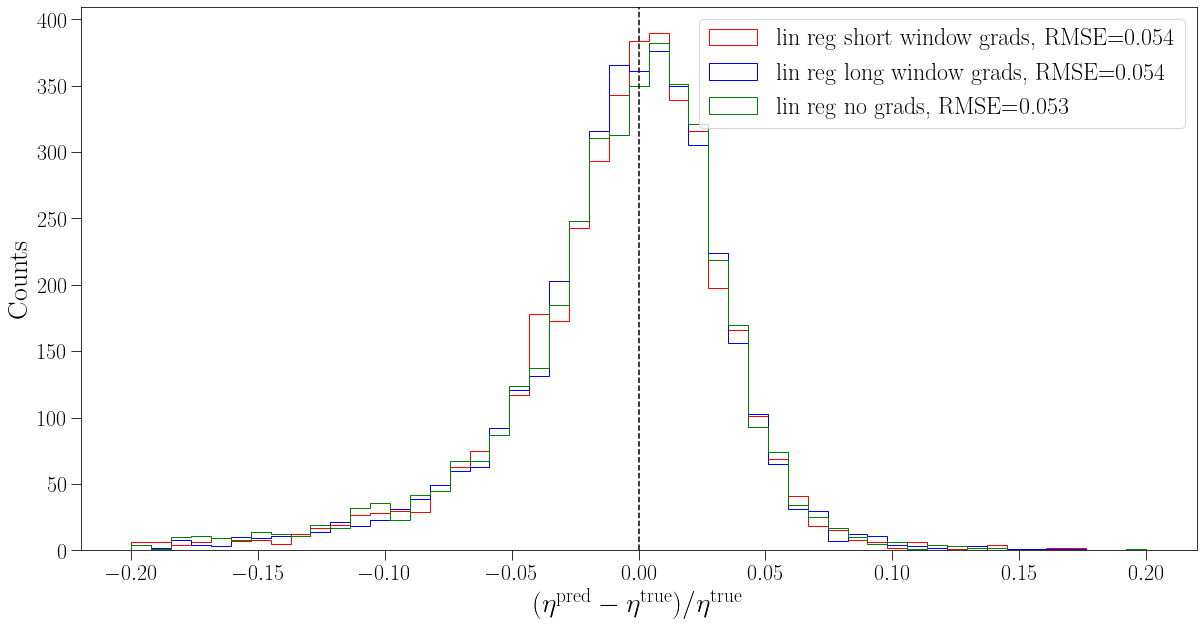

In [40]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, eta_test, eta_models, colors=colors, names=names, models=models, latex_var=r'\eta', 
                   n_bins=51, xrange=(-0.2, 0.2), am_test=am_test)

MV-TLR-4 corr: 0.4821632899713105
MV-TLR-4 RMSE: 0.9628535524459843
MV-TLR-20 corr: 0.4831253355369746
MV-TLR-20 RMSE: 0.9481544747172329
MV-TLR-no_grad corr: 0.4832150695551464
MV-TLR-no_grad RMSE: 0.917191867625848


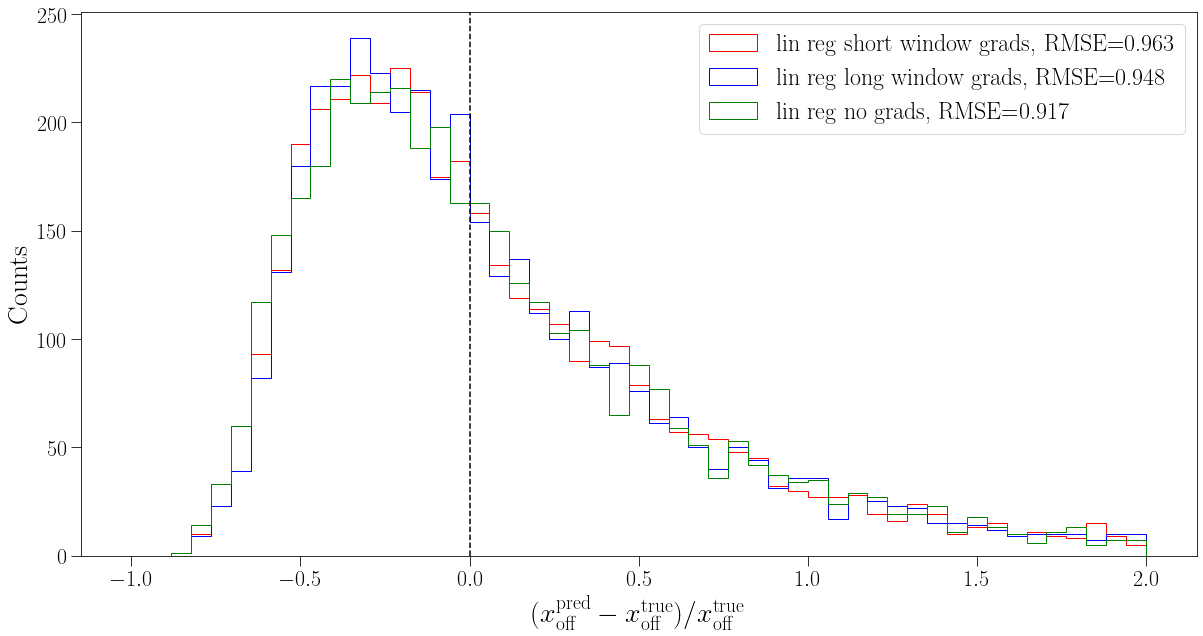

In [42]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, xoff_test, xoff_models, colors=colors, names=names, models=models, latex_var=r'x_{\rm off}', 
                   n_bins=51, xrange=(-1, 2), am_test=am_test)

MV-TLR-4 corr: 0.7966113699485073
MV-TLR-4 RMSE: 0.3510486277594051
MV-TLR-20 corr: 0.7944817544195688
MV-TLR-20 RMSE: 0.35710462962474915
MV-TLR-no_grad corr: 0.7701622689615925
MV-TLR-no_grad RMSE: 0.3382013828982824


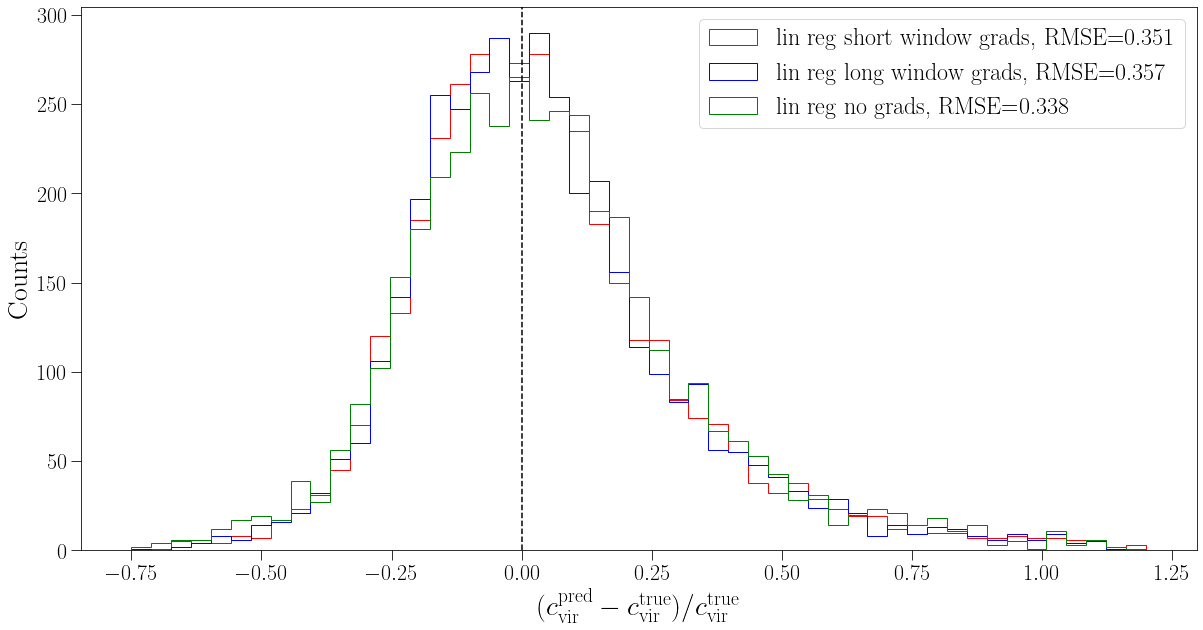

In [45]:
models = ['MV-TLR-4', 'MV-TLR-20', 'MV-TLR-no_grad']
names = ["\\rm lin reg short window grads","\\rm lin reg long window grads", "\\rm lin reg no grads"]
colors = ['r', 'b', 'g']
data = {'MV-TLR-4': test_features4, 'MV-TLR-20': test_features20, 'MV-TLR-no_grad': am_test}
combined_histogram(data, cvir_test, cvir_models, colors=colors, names=names, models=models, latex_var=r'c_{\rm vir}', 
                   n_bins=51, xrange=(-.75, 1.2), am_test=am_test)

CAM1 corr: 0.6825616641826968
CAM1 RMSE: 0.3512874321669475
CAM2 corr: 0.682562346609366
CAM2 RMSE: 0.3932709638677639
MV-TLR corr: 0.7571767818311554
MV-TLR RMSE: 0.3686253123808684


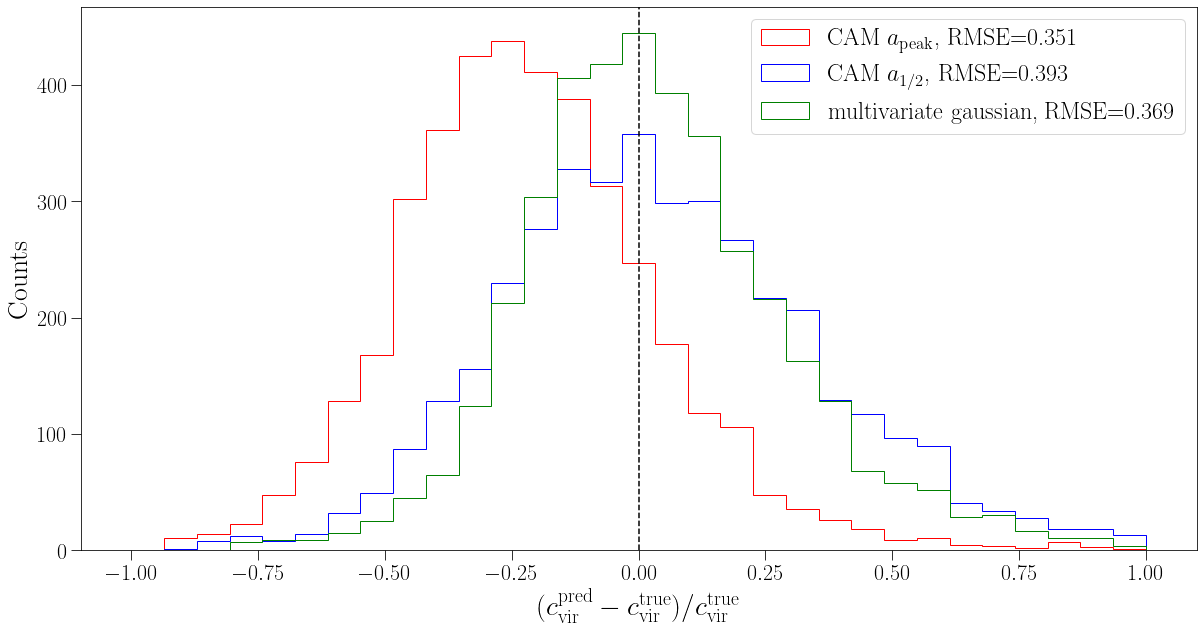

In [21]:
models = ['CAM1', 'CAM2', 'MV-TLR']
names = ["\\rm CAM $a_{\\rm peak}$","\\rm CAM $a_{1/2}$", "\\rm multivariate gaussian"]
colors = ['r', 'b', 'g']
data = {m:am_test for m in models}
combined_histogram(data, cvir_test, cvir_models, colors=colors, names=names, models=models, latex_var=r'c_{\rm vir}', 
                   n_bins=31, xrange=(-1.0, 1.0), am_test=am_test)

In [28]:
eta_models

{'MV-TLR': <function relaxed.analysis.training_suite.<locals>.linreg_trans(x_test, **kwargs)>,
 'CAM1': <function relaxed.analysis.training_suite.<locals>.cam(x_test, am_test=None, **kwargs)>,
 'CAM2': <function relaxed.analysis.training_suite.<locals>.cam(x_test, am_test=None, **kwargs)>}

CAM1 corr: 0.5429441752913177
CAM1 RMSE: 0.08486042064098043
CAM2 corr: 0.543104350453932
CAM2 RMSE: 0.07223125047649699
MV-TLR corr: 0.6847847331202929
MV-TLR RMSE: 0.053682692248045664


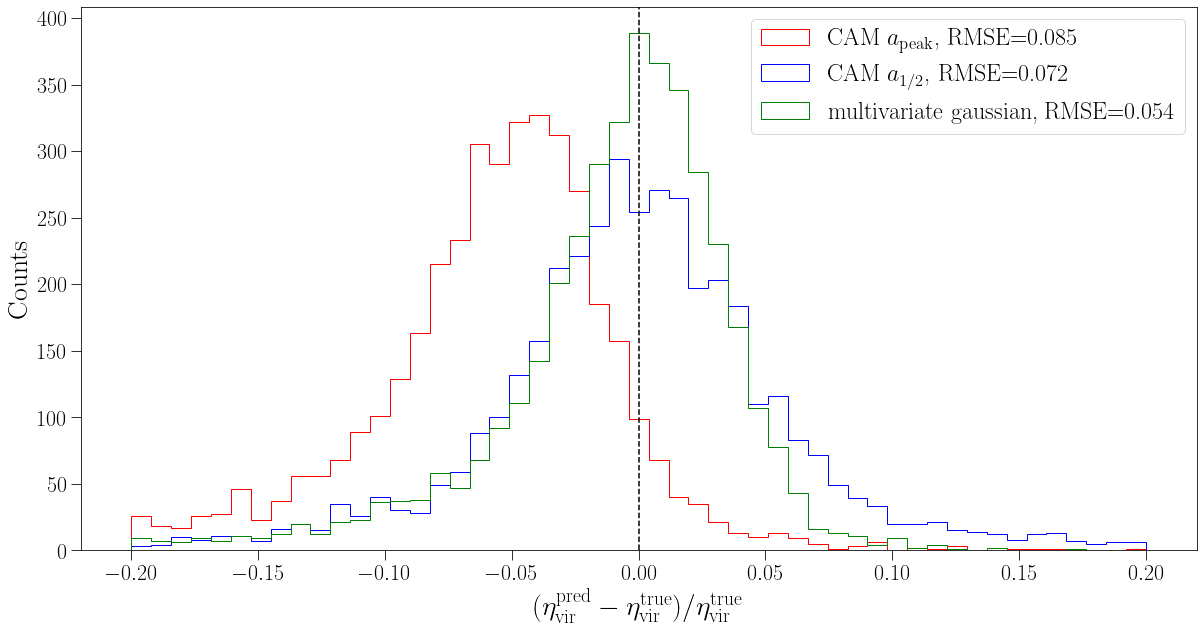

In [30]:
models = ['CAM1', 'CAM2', 'MV-TLR']
names = ["\\rm CAM $a_{\\rm peak}$","\\rm CAM $a_{1/2}$", "\\rm multivariate gaussian"]
colors = ['r', 'b', 'g']
data = {m:am_test for m in models}
combined_histogram(data, eta_test, eta_models, colors=colors, names=names, models=models, latex_var=r'\eta_{\rm vir}', 
                   n_bins=51, xrange=(-0.2, 0.2), am_test=am_test)

In [57]:
eta_models.keys()

dict_keys(['MV-TLR', 'CAM1', 'CAM2'])